In [ ]:
library(tidyr)
library("pxweb")
library("tidyverse")
library("GGally")
library("ggpubr")
library(gridExtra)
library(cowplot)
library("olsrr")
fig <- function(width, heigth) {
    options(repr.plot.width = width, repr.plot.height = heigth)
}


Använd kommandot jupyter nbconvert --to notebook --config jupyter_nbconvert_config.json --output new_notebook.ipynb project.ipynb i anaconda terminalen för att kompilera 

## Introduction
As im approaching my Bachelor's thesis i started thinking about how many other Swedes would graduate "with me". This in turn made me remember that alot of people started studying during the pandemic, partly i think because the decrease in jobs and the decline of the economy. 

Because of these thoughts i decided to investigate how the amount of people graduating from Universities and College in Sweden is affected by different factors such as their gender and the consumer price index among other things.
## Gathering data
I started by looking at the data available from Statistics Sweden, where i found data about [awarded degrees](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__UF__UF0550__UF0550C/Historisk11bN/) by gender and academic year, [Sweden's population](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101G/BefUtvKon1749/) by gender and year ,[average yearly income](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__HE__HE0103__HE0103A/ArbInk28/) by gender and year and [consumer price index](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__HE__HE0103__HE0103A/ArbInk28/) by year.

After finding the data it was time to import it into R, this was simple as Statistics Sweden have their own API.

In [ ]:
API_wait <- 1e-3
pxq_edu <-
  list(
    "Examen" = c("*"),
    "Kon" = c("*"),
    "ContentsCode" = c("000004NE"),
    "Tid" = c("*")
  )
pxg_edu <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN", pxq_edu)
Sys.sleep(API_wait) # To prevent overloading the API

pxq_pop <-
  list(
    "Kon" = c("*"),
    "ContentsCode" = c("000000LV"),
    "Tid" = c("*")
  )

pxg_pop <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/BefUtvKon1749", pxq_pop)
Sys.sleep(API_wait)


pxq_income <- list(
  "Kon" = c("*"),
  "Tid" = c("*"),
  "ContentsCode" = c("HE0103CL")
)
pxg_income <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0103/HE0103A/ArbInk28", pxq_income)
Sys.sleep(API_wait)

pxq_kpi <- list(
  "Tid" = c("*"),
  "ContentsCode" = c("000004VU")
)
pxg_kpi <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/PR/PR0101/PR0101A/KPItotM", pxq_kpi)


After gathering the data it is time to clean it and combine all the different sources into a single tibble.

In [ ]:
edu_df <- as.data.frame(pxg_edu)
edu_df <- as_tibble(edu_df)

doktor_df <- edu_df %>%
    filter(examen %in% c("Doktorsgrad", "Doktorsexamen")) %>%
    group_by(läsår, kön) %>%
    mutate(`Utfärdade examina vid universitet och högskolor` = sum(`Utfärdade examina vid universitet och högskolor`)) %>%
    filter(examen == "Doktorsexamen") %>%
    ungroup()


licenciat_df <- edu_df %>%
    filter(examen %in% c("Licentiatexamen", "Licentiatexamen (Äldre)")) %>%
    group_by(läsår, kön) %>%
    mutate(`Utfärdade examina vid universitet och högskolor` = sum(`Utfärdade examina vid universitet och högskolor`)) %>%
    filter(examen == "Licentiatexamen") %>%
    ungroup()


edu_df <- edu_df %>%
    filter(examen == "Examen från grundutbildning") %>%
    full_join(licenciat_df) %>%
    full_join(doktor_df) %>%
    pivot_wider(names_from = kön, values_from = `Utfärdade examina vid universitet och högskolor`) %>%
    mutate(läsår = as.integer(str_extract(läsår, "^\\w*"))) %>%
    rename(år = läsår) %>%
    pivot_longer(!c(år, examen), names_to = "kön", values_to = "antal") %>%
    mutate(
        kön = str_replace(kön, "båda könen", "totalt"),
        examen = factor(examen,
            ordered = FALSE,
            levels = c(
                "Examen från grundutbildning", "Licentiatexamen", "Licentiatexamen (Äldre)", "Doktorsgrad", "Doktorsexamen"
            ),
            labels = c(
                "Grundutbildning", "Licentiatexamen", "Licentiatexamen", "Doktorsexamen", "Doktorsexamen"
            )
        )
    )

pop_df <- as.data.frame(pxg_pop)
pop_df <- as_tibble(pop_df) %>% mutate(år = as.integer(år)) # %>%



income_df <- as.data.frame(pxg_income)
income_df <- as_tibble(income_df) %>%
    filter(år >= 1936) %>%
    mutate(år = as.integer(år))


kpi_df <- as.data.frame(pxg_kpi)
kpi_df <- as_tibble(kpi_df) %>%
    mutate(månad = str_extract(månad, "(20|19)[\\d]{2}")) %>%
    rename("år" = "månad") %>%
    group_by(år) %>%
    mutate(år = as.integer(år)) %>%
    summarize(`AVG_KPI_Fastställd` = mean(`KPI, fastställda tal`)) %>%
    ungroup()


final_df <- edu_df %>%
    left_join(income_df, by = join_by("år", kön == kön)) %>%
    left_join(kpi_df, by = "år") %>%
    left_join(pop_df, by = join_by("år", kön == kön)) %>%
    rename(medelinkomst = `Medelvärde, tkr`) %>%
    mutate(kön = factor(kön, levels = c("totalt", "kvinnor", "män"), ordered = FALSE)) %>%
    drop_na()

final_df %>% filter(år == 1980)


## Exploring data
Once the data is in a usable format its time to do some exploratory data analysis.
First we look at a scatterplot to get an understanding for the relation between awarded degrees and average income and then we will look at a pairs plot.


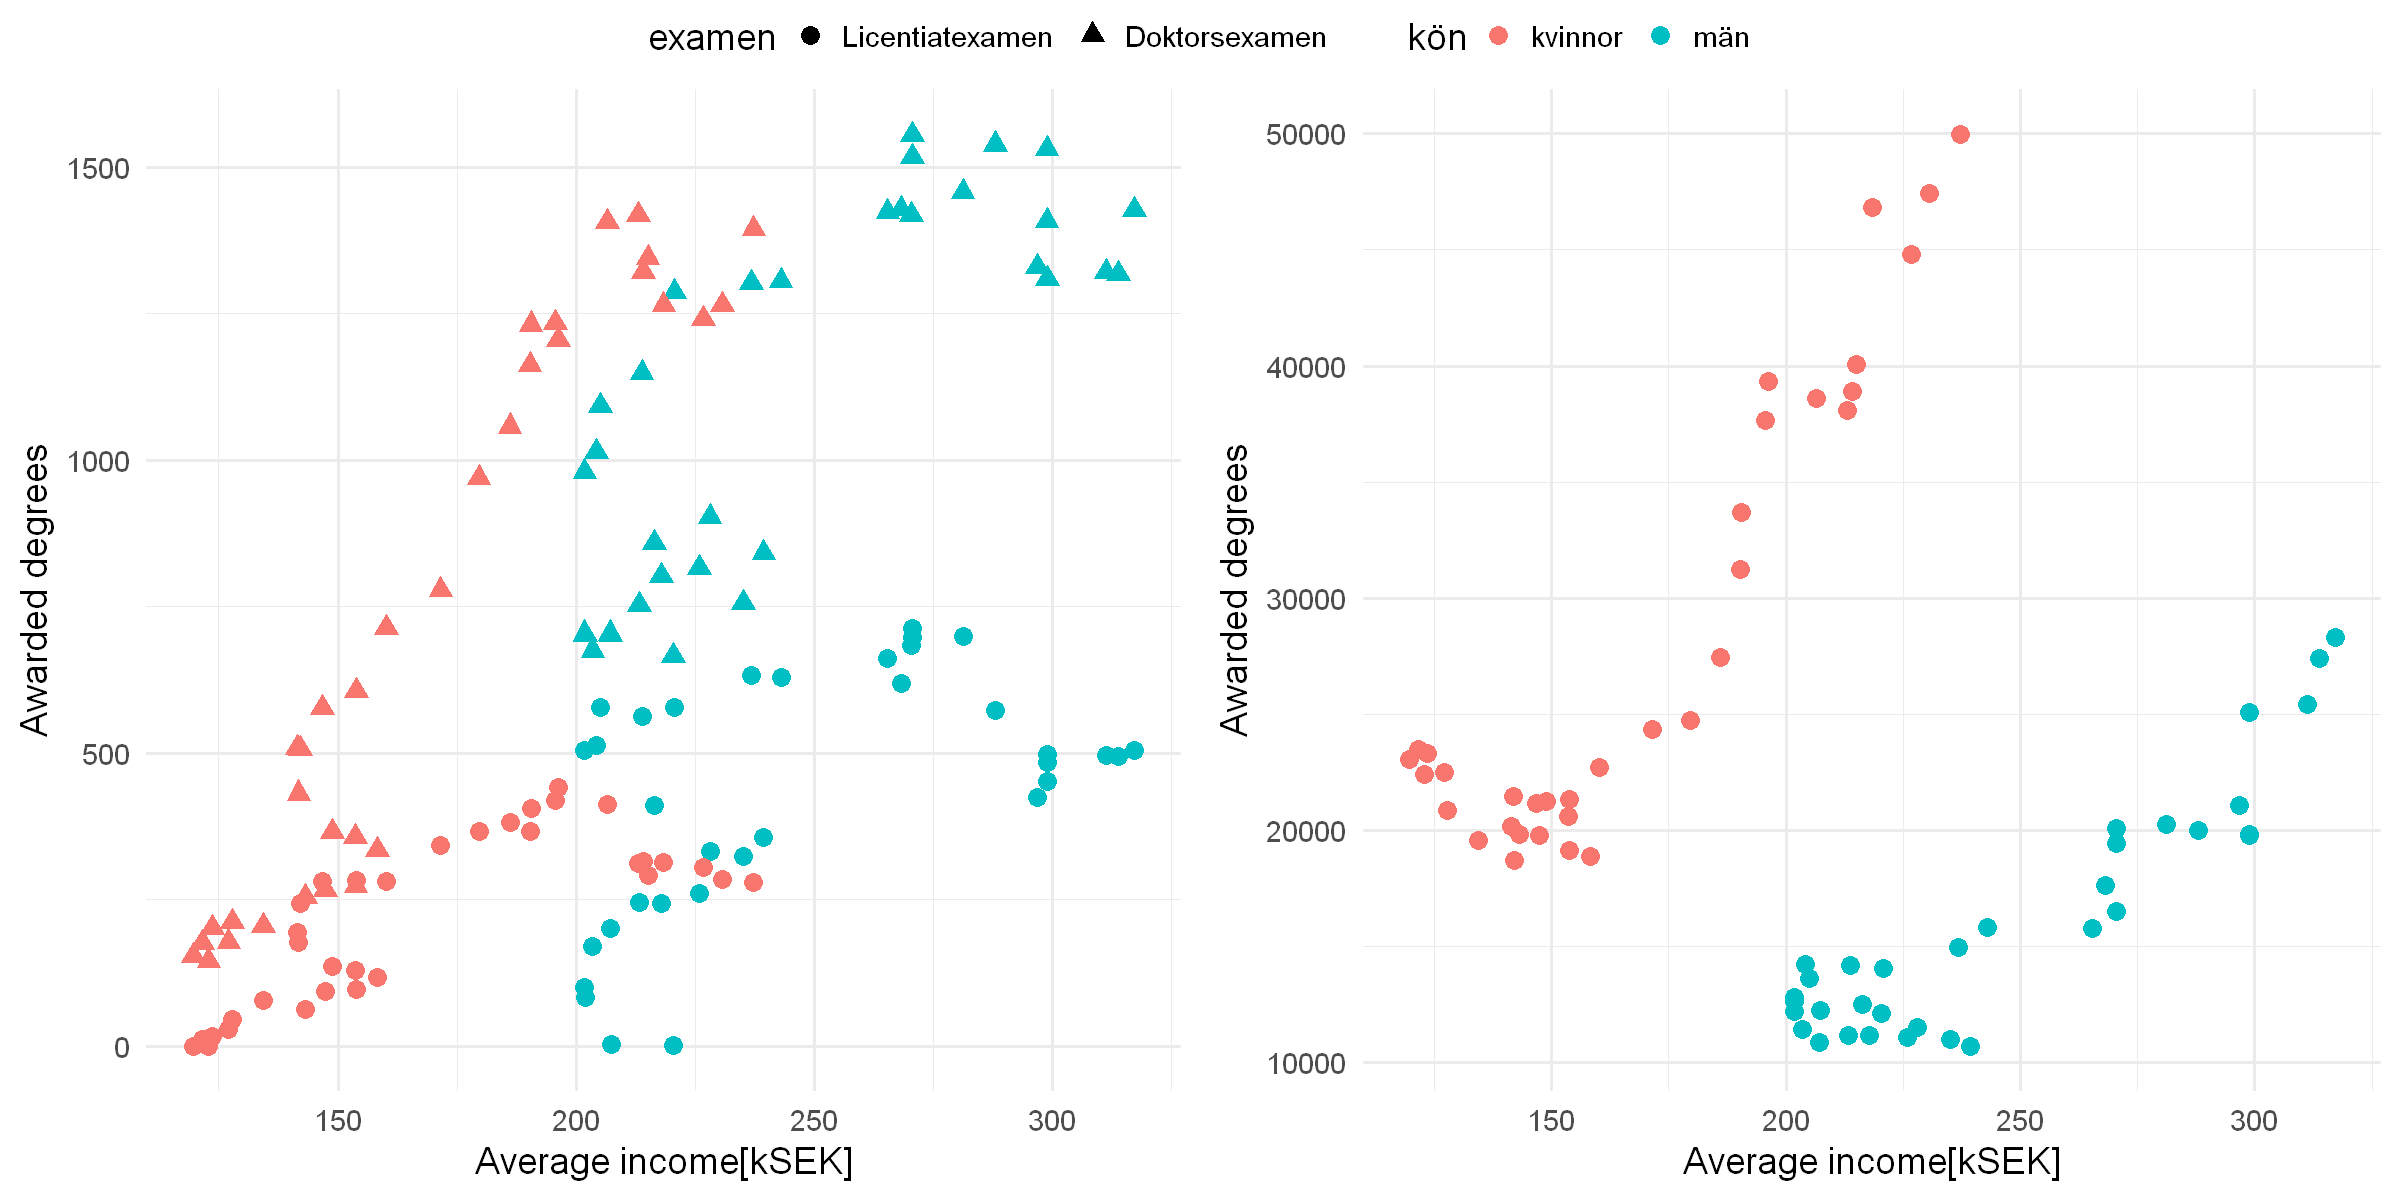

In [78]:
fig(20, 10)
income_deg_plot1 <- ggplot(data = final_df %>% filter(examen != "Grundutbildning", kön != "totalt")) +
  geom_point(aes(x = medelinkomst, y = antal, color = kön, shape = examen), size = 5) +
  theme_minimal(base_size = 22) +
  labs(x = "Average income[kSEK]", y = "Awarded degrees")

income_deg_plot2 <- ggplot(data = final_df %>% filter(examen == "Grundutbildning", kön != "totalt")) +
  geom_point(aes(x = medelinkomst, y = antal, color = kön, shape = examen), size = 5) +
  theme_minimal(base_size = 22) +
  labs(x = "Average income[kSEK]", y = "Awarded degrees")


ggarrange(nrow = 1, ncol = 2, common.legend = TRUE, income_deg_plot1, income_deg_plot2)


On the left we have Licenciat and PHD degrees as dots and triangles respectively, on the right we have Bachelor's degrees. The red datapoints are women and the blue men, not also that average income is not overall but by gender.  We can see that the number of degrees are somewhat similiar between the genders for Licenciat and PHD regardless of average income, and that overall there are more PHD's. But on the Bachelor's wee can see that women are awarded more degrees than men regardless of average income. We can also see that the number of degrees grows with income in both plots.

We will now look at a pairs plot for PHD and Bachelor's degrees on the left and right respectively, note that the population variable Folkmängd has been scaled to millions of people to not clutter the axes.

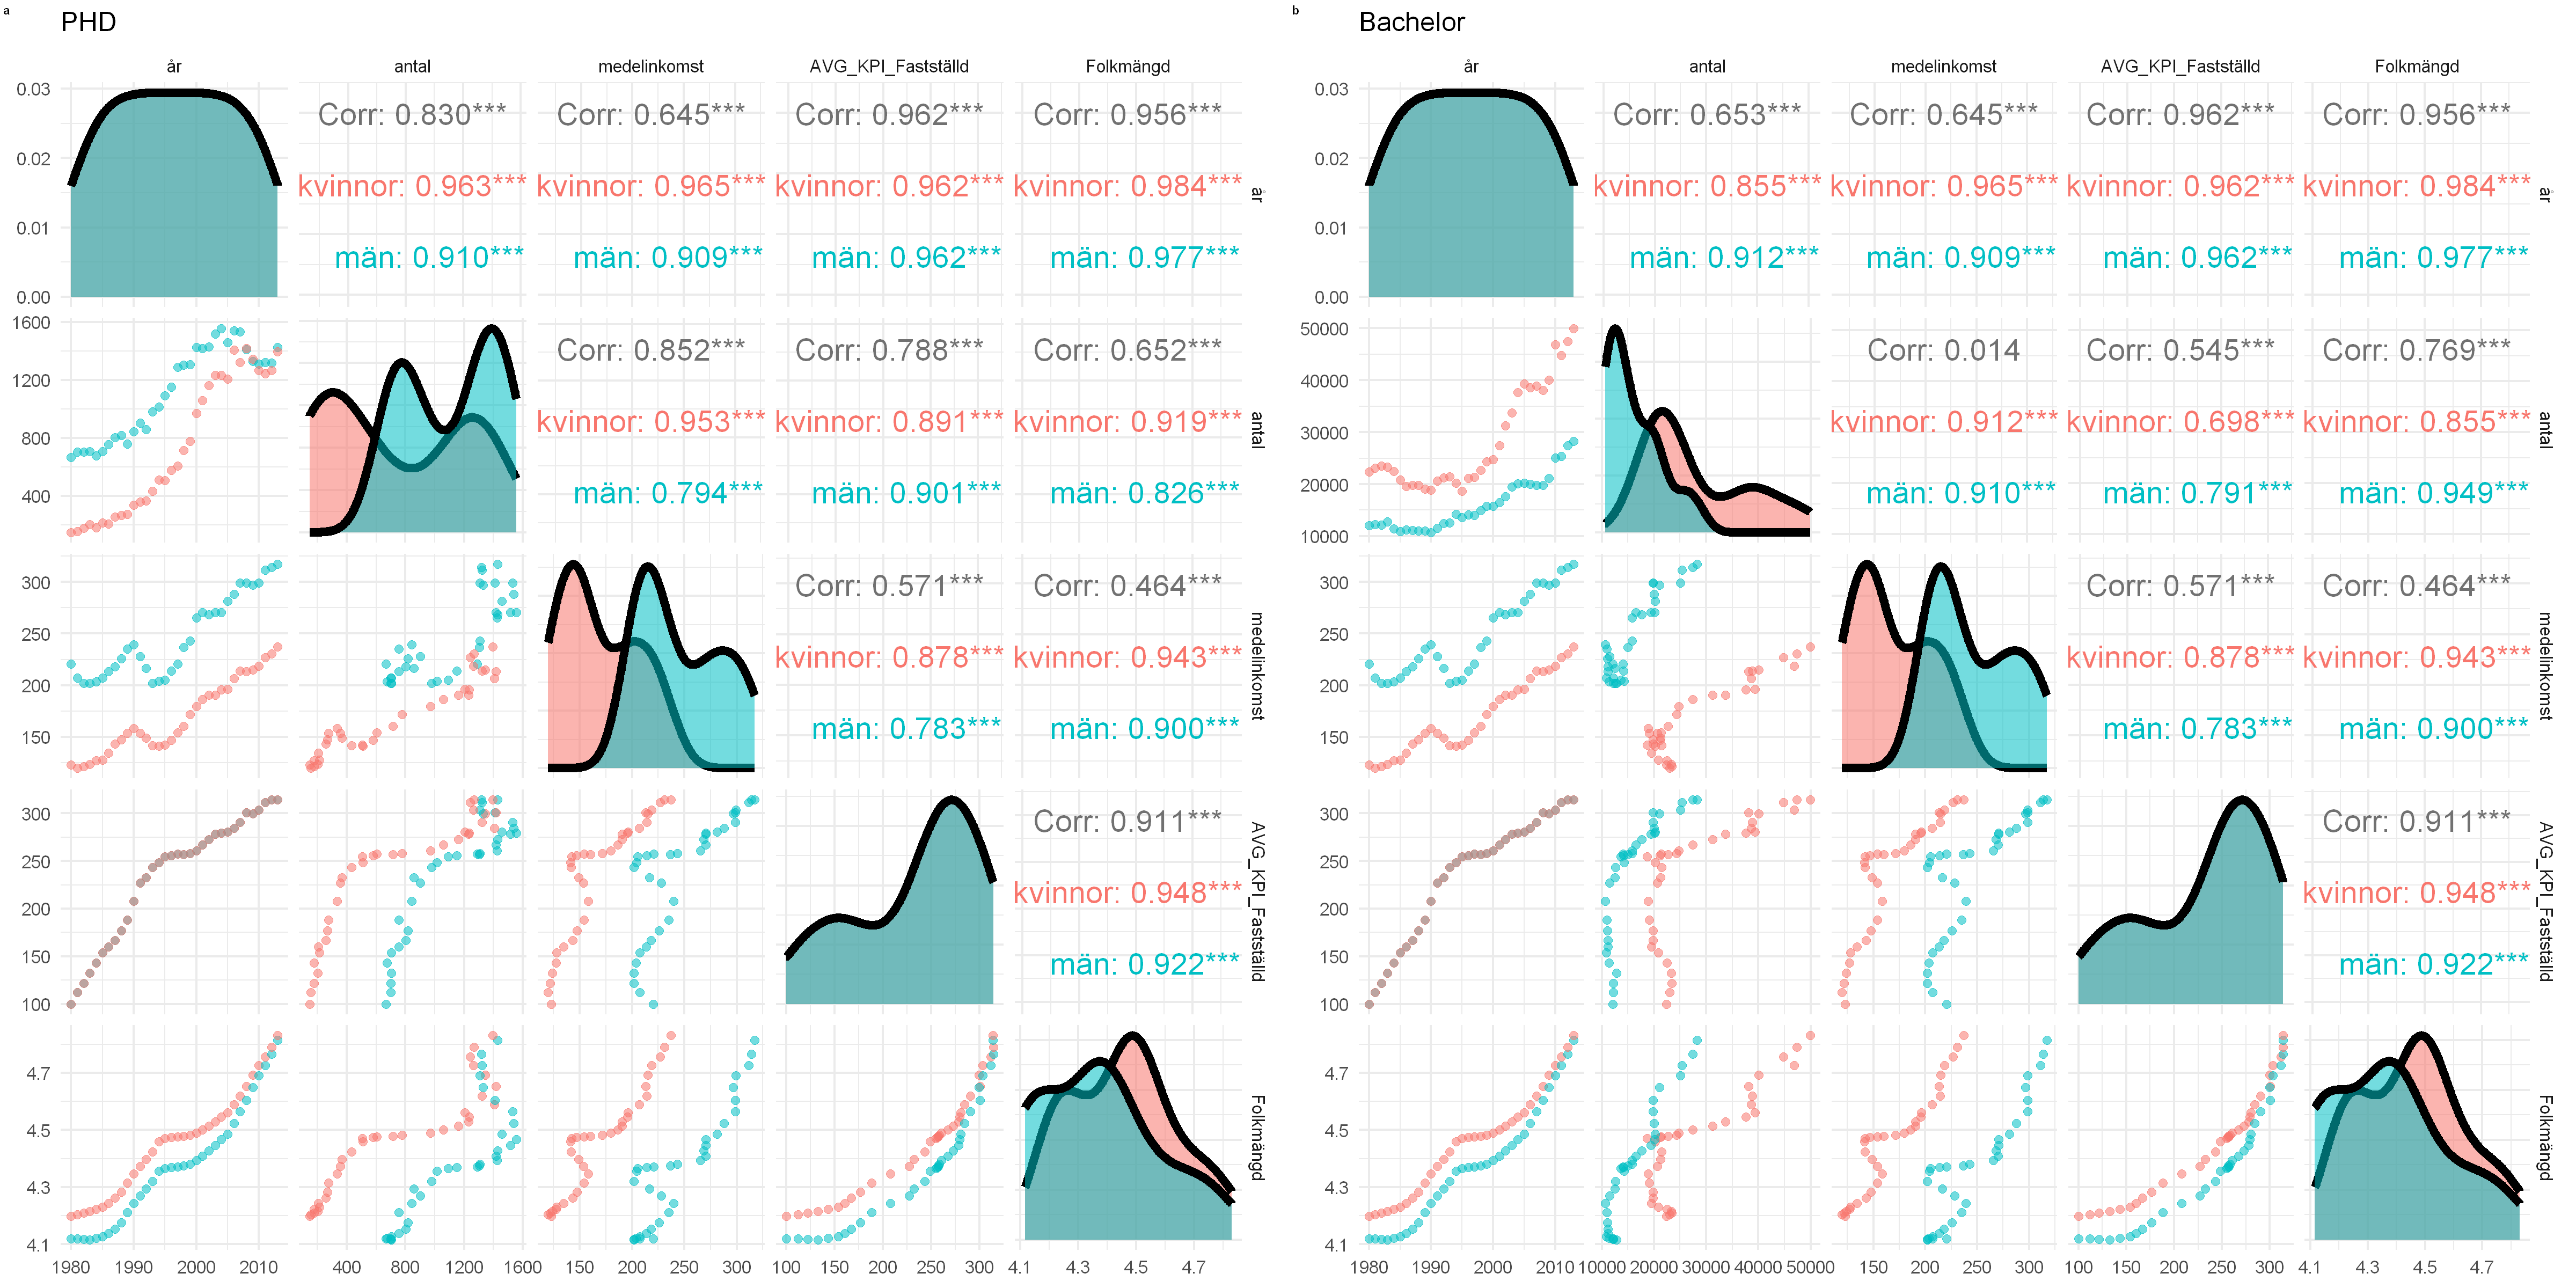

In [79]:
fig(40, 20)
custom_density <- function(data, mapping, ...) {
    ggplot(data = data, mapping = mapping) +
        geom_density(..., alpha = 0.7, color = NA)
}
dok_df <- final_df %>%
    filter(examen == "Doktorsexamen", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

lic_df <- final_df %>%
    filter(examen == "Licentiatexamen", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

grund_df <- final_df %>%
    filter(examen == "Grundutbildning", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

dok_pairs <- ggpairs(
    data = dok_df,
    columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön, alpha = 0.7, size = 5),
    upper = list(continuous = wrap("cor", size = 12)),
) + theme_minimal(base_size = 25) + labs(title = "PHD")

lic_pairs <- ggpairs(
    data = lic_df, columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

grund_pairs <- ggpairs(
    data = grund_df, columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön, alpha = 0.7, size = 5),
    upper = list(continuous = wrap("cor", size = 12))
) + theme_minimal(base_size = 25) + labs(title = "Bachelor")

plot_grid(
    ggmatrix_gtable(dok_pairs), ggmatrix_gtable(grund_pairs),
    labels = "auto", # ggmatrix_gtable(lic_pairs),
    ncol = 2
)


Firstly we can note that the plots for some of the variables are identical between the two degrees, this is because some of the variables are independent of gender and-or type of degree.

We can also see that there there seems to be some collinearity between for example amount of degrees and average income. It is also clear that there seems to be some sort of relation between all of the variables with some differences between type of degree, even if they might not be linear.


## Multiple linear regression models
To further investigate the data we will look at some multiple linear regression models to predict the amount of graduates. We will start with a naive approach using all of the available variables, as a sort of baseline.

In [ ]:
naive_model <- lm(antal ~ år + kön + examen + medelinkomst + Folkmängd + AVG_KPI_Fastställd, data = final_df %>% filter(kön != "totalt"))
summary(naive_model)


In [ ]:
naive_model2 <- lm(antal ~ år + kön + examen + medelinkomst + AVG_KPI_Fastställd, data = final_df %>% filter(kön != "totalt"))
summary(naive_model2)


This naive model results in a relatively high $R^2$ and $R_{adj}^{2}$ values of $R^2=0.836, R_{adj}^{2}=0.830$. The most significant regressors were the average KPI that year and if the degree was a "Licenciat" or PH. That the type of degree was significant is not at all unexpected as a Bachelor's level degree is a prerequesite for further studies. That KPI was significant could hint at the state of the economy being important in people studying or not. But the model is quite hard to interpret as a person and could suffer from overfitting, because of the large amount of explanatory variables. Because of this the regressor with the highest $p$-value was removed from the model, this being the population variable.

The new model had $R^2=0.836, R_{adj}^{2}=0.831$ meaning it performed slightly better than the naive model. Altough it should be noted that all of the $p$-values barely changed.

In order to increase the interpretability of the model and to more easily choose our variables, we will instead create two new models one for the amount of people graduating with a Bachelor's level degree and another for the amount of people graduating with either a "Licenciat" or PHD. The reason for splitting the model between the degrees is that the amount of graduates are far more similiar between Licenciat and PHD than between the two and Bachelor's level.

We will also aproach the problem of choosing variables in the opposite way from what was done to the naive model, that is we will add one variable at a time instead of removing them.


In [ ]:
bachelor_model <- lm(antal ~ ., data = final_df %>% filter(examen == "Grundutbildning", kön != "totalt") %>% select(!examen))
ols_step_forward_p(bachelor_model)

higher_ed_model <- lm(antal ~ ., data = final_df %>% filter(examen != "Grundutbildning", kön != "totalt") %>% mutate(examen = factor(examen)))
ols_step_forward_p(higher_ed_model)


The variable selection algorithm for the Bachelor's level model resulted in the following choices:
1. Population
2. Gender
3. Average income
4. Average consumer price index
5. Year

On first glance this result was surprising to me as the first variable it chose was population in contrast to the naive model were it had the largest $p$-values, and that the variable with the lowest $p$-value except type of degree was added second to last.

Although from the pairs plot we knew that there was collinearity between some of the variables so it is to be expected that they would interact in non intuitive ways. 

For the model of the other two degrees, forward selection resulted in the choices:
1. Degree type
2. Average income
3. Average consumer price index
4. Population
5. Year
6. Gender

It is not surprising that the degree type was the first choice as it feels reasonable that the type of degree would strongly correlate with the amount of graduates. 

But the variables chosen after surprised me a bit more, gender seems to be far less impactful than for the Bachelor's level. Although this could have been somewhat anticipated as the initial scatterplot showed far more separation between genders for the Bachelor's level than for Licenciat or PHD.

It also seems that my initial thoughts that the state of the economy would impact the amount of graduates is more accurate for Licenciat and PHD degrees than for a Bachelor's. The representation of the economy by consumer price index and average income is a huge simplification but it at least gives an indication.

For comparison between the naive model the $R^2$ values surpassed that of the naive model by the third and fourth variable respectively for the Bachelor's and Licenciat/PHD model. At this point the values were $R^2=0.844,R_{adj}^2=0.836$ and  $R^2=0.851,R_{adj}^2=0.846$ for the Bachelor and PHD model.


Im curious about how the variables chosen by the forward selection would affect number of graduates at the point when the models surpassed the naive one. 


In [ ]:
final_model <- lm(antal ~ kön + medelinkomst + Folkmängd, data = final_df %>% filter(examen == "Grundutbildning", kön != "totalt") %>% select(!examen))
summary(final_model)

final_model2 <- lm(antal ~ Folkmängd + examen + medelinkomst + AVG_KPI_Fastställd, data = final_df %>% filter(examen != "Grundutbildning", kön != "totalt"))
summary(final_model2)


For the final model of Bachelor graduates the amount of men seems to be lower than women as the coefficient is negative. Both average income and population had positive coefficients which means that the amount of graduates seems to grow with both increasing income and population. It seems intuitive that it grows with population but somewhat contrary to my initial belief it increases instead of decreases with increased income. Although this is could be due to my representation of the economy not really being accurate.

The final model for PHD/Licenciat graduates has a negative coefficient for the population variable which really surprised me. More PHD's seem to graduate yearly as the coefficient is positive, and as for the Bachelor's model the coefficient for average income is positive. The consumer price index also has a positive coefficient.

